In [4]:
import mxnet as mx
import pandas as pd
from sklearn.model_selection import train_test_split

### Basic Statistics

In [8]:
# Read data and basic statistics
hr_data = pd.read_csv("data/hr.csv")
hr_data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [9]:
hr_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
number_project           14999 non-null int64
average_montly_hours     14999 non-null int64
time_spend_company       14999 non-null int64
Work_accident            14999 non-null int64
left                     14999 non-null int64
promotion_last_5years    14999 non-null int64
sales                    14999 non-null object
salary                   14999 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [10]:
hr_data.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


### Data Preparation

In [20]:
from sklearn import preprocessing

#Convert some features to numeric
sales_unique = hr_data['sales'].unique().tolist()
sales_encoder = preprocessing.LabelEncoder()
sales_encoder.fit(sales_unique)

hr_data['sales'] = sales_encoder.transform(hr_data['sales'])

salary_unique = hr_data['salary'].unique().tolist()
salary_encoder = preprocessing.LabelEncoder()
salary_encoder.fit(salary_unique)

hr_data['salary'] = salary_encoder.transform(hr_data['salary'])

In [30]:
# Separate data in training and testing
X = hr_data.drop(['left'], axis=1)
y = hr_data['left']

# Normalization is required for NN
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns=X.columns)

In [31]:
# Set validation parameters
sample_size = int(0.7 * hr_data.shape[0])
sample_seed = 0

# Separate training and validation
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=sample_size, random_state=sample_seed)

### Build Neural Net

In [42]:
data = mx.symbol.Variable('data')
fc1 = mx.symbol.FullyConnected(data, name='fc1', num_hidden=3)
act1 = mx.symbol.Activation(fc1, name='sig1', act_type="sigmoid")
fc2 = mx.symbol.FullyConnected(act1, name='fc2', num_hidden=2)
act2 = mx.symbol.Activation(fc2, name='sig2', act_type="sigmoid")
fc3 = mx.symbol.FullyConnected(act2, name='fc3', num_hidden=2)
#mlp = mx.symbol.SoftmaxOutput(fc3, name='softmax', multi_output=True)
mlp = mx.symbol.SoftmaxOutput(fc3, name='softmax')

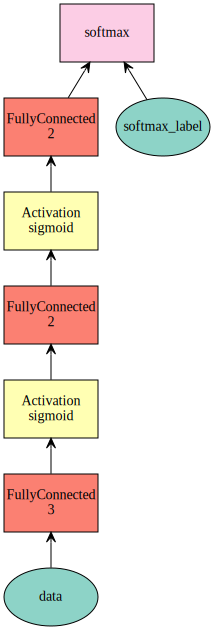

In [43]:
mx.viz.plot_network(mlp)

### Train the net

In [81]:
import logging
logging.basicConfig(level=logging.INFO)

mod = mx.mod.Module(symbol=mlp, context=mx.cpu(), data_names=['data'], label_names=['softmax_label'])

batch_size = 5
learning_rate = 0.3

train_iter = mx.io.NDArrayIter(data={'data':X_train.values},
                            label={'softmax_label':y_train.values},
                            batch_size=batch_size)

eval_iter = mx.io.NDArrayIter(data={'data':X_test.values},
                            label={'softmax_label':y_test.values},
                            batch_size=batch_size)

mod.fit(train_iter,
        optimizer='sgd',
        optimizer_params={'learning_rate':learning_rate},
        eval_metric='accuracy',
        num_epoch=10)

INFO:root:Epoch[0] Train-accuracy=0.758476
INFO:root:Epoch[0] Time cost=1.098
INFO:root:Epoch[1] Train-accuracy=0.754857
INFO:root:Epoch[1] Time cost=1.243
INFO:root:Epoch[2] Train-accuracy=0.757429
INFO:root:Epoch[2] Time cost=1.196
INFO:root:Epoch[3] Train-accuracy=0.794190
INFO:root:Epoch[3] Time cost=1.316
INFO:root:Epoch[4] Train-accuracy=0.853333
INFO:root:Epoch[4] Time cost=1.051
INFO:root:Epoch[5] Train-accuracy=0.894667
INFO:root:Epoch[5] Time cost=1.078
INFO:root:Epoch[6] Train-accuracy=0.915810
INFO:root:Epoch[6] Time cost=1.105
INFO:root:Epoch[7] Train-accuracy=0.926952
INFO:root:Epoch[7] Time cost=1.074
INFO:root:Epoch[8] Train-accuracy=0.931333
INFO:root:Epoch[8] Time cost=1.057
INFO:root:Epoch[9] Train-accuracy=0.936190
INFO:root:Epoch[9] Time cost=1.350


In [82]:
from sklearn.metrics import confusion_matrix

y_pred = mod.predict(eval_iter).asnumpy()
y_pred = map(lambda x: 1 if x[0] < 0.5 else 0, y_pred)

confusion_matrix(y_test, y_pred)

array([[3357,  105],
       [ 191,  847]])

In [83]:
# Calculo métricas de evaluación
score = mod.score(eval_iter, ['mse', 'acc'])
score

[('mse', 0.44885280198521083), ('accuracy', 0.9342222222222222)]